In [1]:
%cd ../.. 

/home/d/PycharmProjects/protein_properties


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [19]:
dataset_results = Path("log/")
model = "SASABaseline"
#pred_classes = pd.read_csv(dataset_results / f"all_{model}_test_preds.tsv", sep='\t')
pred_classes = pd.read_csv("log/SASABaseline_10_test_preds.tsv", sep="\t")
dummies = np.eye(10)[pred_classes["Real_class"]].flatten()
probs = np.array([list(map(float, el[1:-1].split())) for el in pred_classes["Score"]])

In [17]:
def calc_bins(preds):
  # Assign each prediction to a bin
  num_bins = 10
  bins = np.linspace(0.1, 1, num_bins)
  binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = (dummies[binned==bin]).sum() / bin_sizes[bin]
      bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

  return bins, binned, bin_accs, bin_confs, bin_sizes


In [15]:
def get_metrics(preds):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [13]:
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
  ECE, MCE = get_metrics(preds)
  bins, _, bin_accs, _, _ = calc_bins(preds)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True)
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()

  plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)


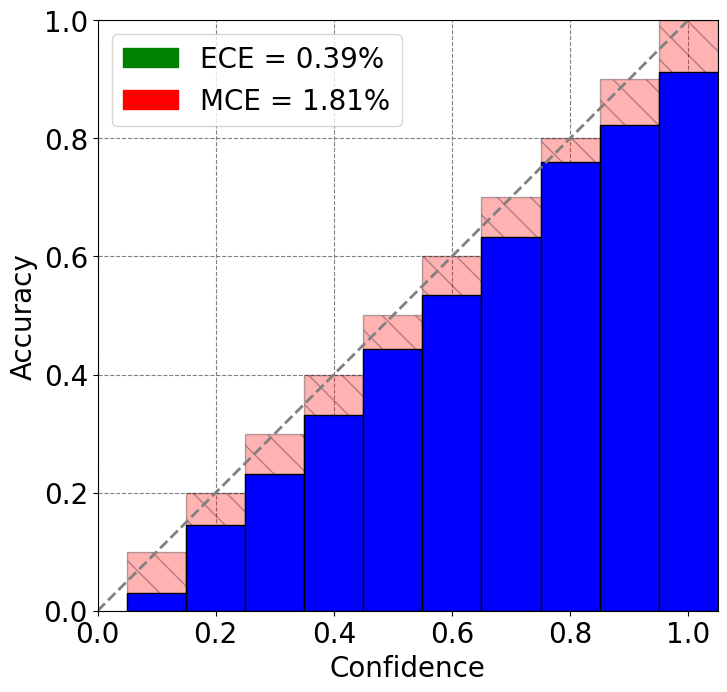

In [20]:
draw_reliability_graph(probs.flatten())

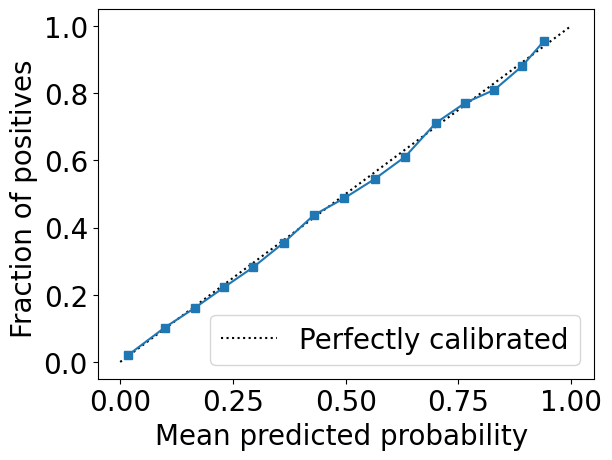

In [21]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

prob_true, prob_pred = calibration_curve(dummies, probs.flatten(), n_bins=15)
disp = CalibrationDisplay(prob_true, prob_pred, probs.flatten())
disp.plot()

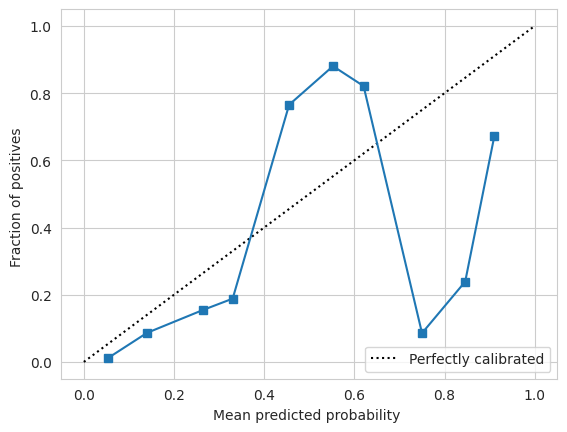

In [19]:
prob_true, prob_pred = calibration_curve(dummies, cal_probs.flatten(), n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, cal_probs.flatten())
disp.plot()

In [20]:
from scipy import stats


In [21]:
stats.pearsonr(np.max(probs, axis=1), pred_classes["Reliability_Score"])

KeyError: 'Reliability_Score'

In [ ]:
import seaborn as sns
from matplotlib.pyplot import show

prob_true, prob_pred = calibration_curve(dummies, probs.flatten(), n_bins=10)
df_plot = pd.DataFrame(data={"True Positive Rate (TPR)":prob_true,"Score (P)":prob_pred,"Probabilities":["Model Default Params"]*len(prob_true)})

prob_true, prob_pred = calibration_curve(dummies, cal_probs.flatten(), n_bins=10)
df_plot = pd.concat([df_plot, pd.DataFrame(data={"True Positive Rate (TPR)":prob_true,"Score (P)":prob_pred,"Probabilities":["Best HP"]*10})], ignore_index=True)

p = sns.lineplot(
	data=df_plot,
	x="Score (P)",
	y="True Positive Rate (TPR)",
	hue="Probabilities",
	style="Probabilities",
	palette=["#09626f", "#6ca992"],
	markers=['P','s','o',','],
	dashes=["","","",(2,4)]
)
p.axline((0, 0), (1, 1), c="grey", ls="--", lw=1)
p.set(title="Calibration Curves")
p.legend(title='Models', loc='upper left')
plt.savefig('calibration_curves.png', bbox_inches='tight', dpi=600)